In [1]:
import re
import numpy as np
import math
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline
import sklearn.datasets
from sklearn import preprocessing, model_selection

# Data loading

In [2]:
# I use the code snippet from https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm/7369986
# It read PGM image buffer string and return a numpy array
def read_pgm2(buffer, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    #with open(filename, 'rb') as f:
    #    buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    #print 'width',width, 'height', height
    
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=15#len(header)
                            ).reshape((int(height), int(width)))

In [3]:
dataset0 = sklearn.datasets.load_files('data/CroppedYale', shuffle=True)

data/CroppedYale/yaleB36/yaleB36_P00A+070E-35.pgm
34
yaleB36
2432


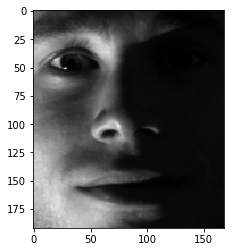

In [4]:
# Here is some sanity checks of the parsed dataset
idx0 = 10 #len(dataset0.filenames)-1
print(dataset0.filenames[idx0])
print(dataset0.target[idx0])
print(dataset0.target_names[dataset0.target[idx0]])
print(len(dataset0.filenames))
image0 = read_pgm2(dataset0.data[idx0])
plt.imshow(image0, plt.cm.gray)

In [5]:
# This cell includes the splittign of training and test set.
X = np.stack(map(read_pgm2, dataset0.data))
# X = X[:size0]

shapeX = X.shape
X = X.reshape((shapeX[0],shapeX[1]*shapeX[2]))
X = preprocessing.scale(X.astype(float),axis=1) # Mean removal and variance scaling

y = dataset0.target
enc = preprocessing.OneHotEncoder()
y = enc.fit_transform(y.reshape(-1, 1)).toarray()
# y = y.reshape(-1)
# y = y[:size0]

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

# Optimal Encoding

In [6]:
from networks import MLP
from OptimalEncoding import OptimalEncoding

Instructions for updating:
Use the retry module or similar alternatives.


## Autoencoding, no min_ent

In [7]:
n_in = X.shape[-1]
n_bits = math.ceil(np.log2(X.shape[0]))
n_out = X.shape[-1]
depth = 2
widths = [300, 300]

In [8]:
encoder = MLP(n_in, n_bits, depth, widths)
decoder = MLP(n_bits, n_out+1, depth, widths)

In [9]:
oe = OptimalEncoding(encoder, decoder, n_bits)

In [10]:
oe.train(X_train, y=None, min_entropy=False, epochs=100, batch_size=64, lr=1e-2, tau_rate = 1e-4)

InvalidArgumentError: Incompatible shapes: [64,32256] vs. [64]
	 [[Node: truediv_1 = RealDiv[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Abs, add_8)]]

Caused by op 'truediv_1', defined at:
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-2818cecaab9e>", line 1, in <module>
    oe = OptimalEncoding(encoder, decoder, n_bits)
  File "/home/hudson/Projects/Optimal-Encoding/OptimalEncoding.py", line 46, in __init__
    tf.abs(self.Y - tf.tanh(self.Y_hat))/(tf.abs(self.std) + EPS) + tf.log(tf.abs(self.std) + EPS),
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 971, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 1067, in _truediv_python3
    return gen_math_ops.real_div(x, y, name=name)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 5632, in real_div
    "RealDiv", x=x, y=y, name=name)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3290, in create_op
    op_def=op_def)
  File "/home/hudson/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1654, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Incompatible shapes: [64,32256] vs. [64]
	 [[Node: truediv_1 = RealDiv[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Abs, add_8)]]


In [ ]:
zhat = oe.encode(X_train)
zhard = (np.abs(zhat - 1) < .1).astype(int)
unique, counts = np.unique(zhard, axis=0,return_counts=True)
print("Used %d encodings out of a possible %d  (%.2f%%)"  %(len(unique), 2**n_bits, 100*len(unique)/float(2**n_bits)))
p = counts/np.sum(counts)
H = sum(-p*np.log2(p))
print("Used %.2f bits out of a possible %d  (%.2f%%)"  %(H, n_bits, 100*H/float(n_bits)))
print("Expected %.2f encodings out of a possible %d  (%.2f%%)"  %(2**H, 2**n_bits, 100*2**H/float(2**n_bits)))


In [ ]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_train[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$, z=%s" %(j, zhard[j]))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

In [ ]:
zhat = oe.encode(X_test)
zhard = (np.abs(zhat - 1) < .1).astype(int)
unique, counts = np.unique(zhard, axis=0,return_counts=True)
print("Used %d encodings out of a possible %d  (%.2f%%)"  %(len(unique), 2**n_bits, 100*len(unique)/float(2**n_bits)))
p = counts/np.sum(counts)
H = sum(-p*np.log2(p))
print("Used %.2f bits out of a possible %d  (%.2f%%)"  %(H, n_bits, 100*H/float(n_bits)))
print("Expected %.2f encodings out of a possible %d  (%.2f%%)"  %(2**H, 2**n_bits, 100*2**H/float(2**n_bits)))


In [ ]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_test[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$, z=%s" %(j, zhard[j]))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

## Autoencoding, yes min_ent

In [ ]:
n_in = X.shape[-1]
n_bits = math.ceil(np.log2(X.shape[0]))
n_out = X.shape[-1]
depth = 2
widths = [300, 300]

In [ ]:
encoder = MLP(n_in, n_bits, depth, widths)
decoder = MLP(n_bits, n_out+1, depth, widths)

In [ ]:
oe = OptimalEncoding(encoder, decoder, n_bits)

In [ ]:
oe.train(X_train, y=None, min_entropy=True, epochs=100, batch_size=64, lr=1e-2, tau_rate = 1e-4)

In [ ]:
zhat = oe.encode(X_train)
zhard = (np.abs(zhat - 1) < .1).astype(int)
unique, counts = np.unique(zhard, axis=0,return_counts=True)
print("Used %d encodings out of a possible %d  (%.2f%%)"  %(len(unique), 2**n_bits, 100*len(unique)/float(2**n_bits)))
p = counts/np.sum(counts)
H = sum(-p*np.log2(p))
print("Used %.2f bits out of a possible %d  (%.2f%%)"  %(H, n_bits, 100*H/float(n_bits)))
print("Expected %.2f encodings out of a possible %d  (%.2f%%)"  %(2**H, 2**n_bits, 100*2**H/float(2**n_bits)))


In [ ]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_train[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$, z=%s" %(j, zhard[j]))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()

In [ ]:
zhat = oe.encode(X_test)
zhard = (np.abs(zhat - 1) < .1).astype(int)
unique, counts = np.unique(zhard, axis=0,return_counts=True)
print("Used %d encodings out of a possible %d  (%.2f%%)"  %(len(unique), 2**n_bits, 100*len(unique)/float(2**n_bits)))
p = counts/np.sum(counts)
H = sum(-p*np.log2(p))
print("Used %.2f bits out of a possible %d  (%.2f%%)"  %(H, n_bits, 100*H/float(n_bits)))
print("Expected %.2f encodings out of a possible %d  (%.2f%%)"  %(2**H, 2**n_bits, 100*2**H/float(2**n_bits)))


In [ ]:
xhat = oe.decode(zhat)

fig, ax = plt.subplots(figsize = (20,10), nrows=2, ncols=5)
for i in range(len(ax)):
    row = ax[i]
    for j in range(len(row)):
        subplt = row[j]
        if i == 0:
            subplt.set_title("$X_%d$" %(j))
            subplt.imshow(X_test[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        if i == 1:
            subplt.set_title("$\hat{X}_%d$, z=%s" %(j, zhard[j]))
            subplt.imshow(xhat[j].reshape((shapeX[1],shapeX[2])), plt.cm.gray)
        
        subplt.axis('off')
        
fig.subplots_adjust(wspace=None, hspace=None)
plt.show()